# DarkMatters example

The first thing we need to do is import all our relevant packages. There are 3 methods we usually need from DarkMatters: `readInputFile`, `runCalculation`, and `makeOutput`. What these do is pretty self evident. 

In [43]:
%load_ext autoreload
%autoreload 2
from dark_matters.input import readInputFile,readDMOutput
from dark_matters.calculations import runCalculation
from dark_matters.output import fitsMap,makeOutput
from astropy import units
from astropy.coordinates import SkyCoord
from matplotlib import pyplot as plt
import numpy as np 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next I will read in the calculation data for the Coma cluster (note there are no displayed units, everything has been converted in DarkMatters internal unit system). For information on how to construct input files refer to the [Wiki](https://github.com/Hyperthetical/DarkMatters/wiki). 

In [37]:
dataSets = readInputFile("coma.yaml")
print(dataSets)

{'haloData': {'haloName': 'coma', 'haloProfile': 'nfw', 'haloScale': 0.287, 'haloCvir': 9.4, 'haloRvir': 2.7, 'haloMvir': 1200000000000000.0, 'haloZ': 0.0231}, 'magData': {'magProfile': 'beta', 'magNorm': 4.7, 'magIndex': -0.327, 'magScale': 0.253, 'magFuncLock': False}, 'gasData': {'gasProfile': 'beta', 'gasNorm': 0.00349, 'gasScale': 0.253, 'gasIndex': -0.654}, 'diffData': {'lossOnly': False, 'diffConstant': 1e+29, 'diffIndex': 1.66666666}, 'partData': {'partModel': 'bb', 'emModel': 'annihilation'}, 'calcData': {'calcMode': 'sb', 'freqMode': 'radio', 'mWIMP': array([  10.,  100., 1000.]), 'fSampleLimits': array([   100., 100000.]), 'fSampleNum': 40, 'fSampleSpacing': 'log', 'adiMaxSteps': 20, 'rSampleNumber': 50, 'eSampleNumber': 50, 'log10RSampleMinFactor': -3, 'electronMode': 'adi-python'}, 'cosmoData': {}}


The dictionary above contains all the entries for the Coma environment and calculation I want to run, namely: haloData, magData, and gasData, diffData, partData, calcData, and cosmoData.
These describe the halo, magnetic field, gas distribution, diffusive environment, particle physics, calculations to run, and cosmology parameters respectively. cosmoData can be left empty and Planck 2019 results will be used by default.

All I need to do is call the runCalculation routine, note that it takes in all the dictionaries and returns them all in a meta dictionary. (On windows you might get warnings about overflow in sparsity calculations, you can ignore these).

In [38]:
outputData = runCalculation(**dataSets)

Beginning DarkMatters calculations
Frequency mode: radio
Calculation type: sb
Run Parameters
Frequency Samples: 40
Minimum Frequency Sampled: 1.00e+02 MHz 
Maximum Frequency Sampled: 1.00e+05 MHz
Radial Grid Intervals: 80
Minimum Sampled Radius: 2.870e-04 Mpc
Maximum Sampled Radius: 5.400e+00 Mpc
Halo Parameters: 
Halo Name: coma
Redshift z: 2.31e-02
Luminosity Distance: 104.031 Mpc
Halo profile: nfw
Virial Mass: 1.200e+15 Solar Masses
Virial Radius: 2.700e+00 Mpc
Halo scale radius: 2.870e-01 Mpc
Rho_s/Rho_crit: 2.157e+04
Virial Concentration: 9.40
Gas Parameters: 
Gas density profile: beta
gasScale: 0.253 Mpc 
gasIndex: -0.654
gasNorm: 0.00349 cm^-3 
Magnetic Field Parameters: 
Magnetic field profile: beta
magNorm: 4.7 micro-Gauss 
magScale: 0.253 Mpc 
magIndex: -0.327
Spatial Diffusion
Turbulence index: 1.67
Diffusion constant: 1.00e+29 cm^2 s^-1
Now calculating for Dark Matter model: 
WIMP mass: 10.0 GeV
Particle physics: bb
Emission type: annihilation
Calculating Electron Equilibri

You might think that took a while to run but note we did 120 separate computations (3 WIMP masses and 40 frequency bins!) Some parameter tuning can be done for optimization (see Wiki).

Now I can store the output, I will do so using the yaml format. The code assigns a name automatically, if I specify the `tag` argument, an additional tag (the value of tag) will be added to the file name.

In [39]:
makeOutput(**outputData,outMode="yaml")

Now I will plot some of the output. Here I will choose one frequency and plot the surface brightness vs angular radius. For surface brightness, `calcData['results']['finalData']` has one array per entry in `calcData['mWIMP']`, each array is `calcData['fSampleNum']` by `calcData['rSampleNum']`. I can see the values using `calcData['fSampleValues']` and `calcData['angSampleValues']` for angular radii (when finding surface brightness only).

If you need to know the units of the results just check the appropriate entries in `calcData['results']['units']`. If you don't like these units you can also have fluxes in erg/cm^2/s instead by setting `calcData['outCGS'] = True`.

{'electronData': '1/cm^3', 'radioEmData': 'GeV/cm^3', 'primaryEmData': 'GeV/cm^3', 'secondaryEmData': 'GeV/cm^3', 'fSampleValues': 'MHz', 'finalData': 'Jy/arcmin^2', 'angSampleValues': 'arcmin'}


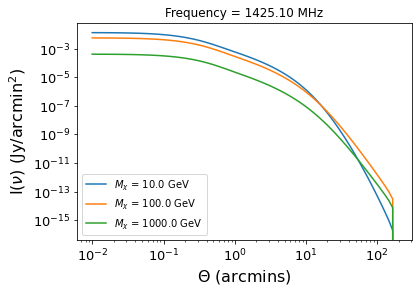

In [41]:
freqIndex = (np.abs(outputData['calcData']['fSampleValues'] - 1400)).argmin() #Nearest frequency to 1400 MHz
print(outputData['calcData']['results']['units'])

for i in range(len(outputData['calcData']['mWIMP'])):
    plt.plot(outputData['calcData']['angSampleValues'],outputData['calcData']['results']['finalData'][i][freqIndex],label=r"$M_\chi$ = "+str(outputData['calcData']['mWIMP'][i])+" GeV")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"I$(\nu)$ (Jy/arcmin$^2$)",fontsize=16)
plt.xlabel(r"$\Theta$ (arcmins)",fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title(f"Frequency = {outputData['calcData']['fSampleValues'][freqIndex]:.2f} MHz")
plt.legend()
plt.show()

Next, I can produce a fits map for use if I need to compare to maps from radio observations (by default the cross-section used here is $10^{-26}$ cm $^3$ s $^{-1}$ but the sigV argument can control this). Note I need to specify the location of the target centre in the form of an astropy SkyCoord object to do this. I have it calculated for 3 frequencies, 900 MHz, 1 GHz, and 1.1 GHz. By specifying display_slice = 0 I get the 900 MHz plot appearing. I can use `targetResolution` (in arcmin) to control the pixel size and `rMax` to determine the maximum radius I want to use (in Mpc). Note that if you make `targetResolution` too small the parameter `maxPix` will kick in and limit resolution to prevent your kernel crashing. All the data is written to a fits file

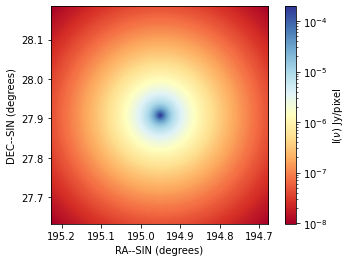

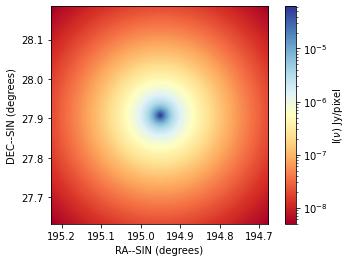

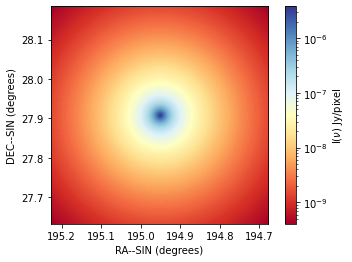

In [ ]:
c = SkyCoord(ra="12h59m48.7s", dec=+27.9086, frame='icrs',unit=(units.hourangle, units.deg))
fitsMap(c,[0.9e3,1.0e3,1.1e3],outputData['calcData'],outputData['haloData'],outputData['partData'],outputData['diffData'],display_slice=0,sigV=1e-26,targetResolution=5/60,rMax=0.5) 

If you want to calculate flux instead of surface brightness, but don't want to redo the electron calculations, you can reload an old calculation and modify the dictionaries as follows

In [52]:
inData = readDMOutput("coma_bb_mx-10-100-1000GeV_annihilation_nfw_adi-python_dl-104.0Mpc_D0-1e+29_sync_sb.yaml")
inData['calcData']['calcMode'] = "flux"
inData['calcData']['calcAngmaxIntegrate'] = 10 #arcmin

*******************************************************
                   Warning
*******************************************************
Loading coma_bb_mx-10-100-1000GeV_annihilation_nfw_adi-python_dl-104.0Mpc_D0-1e+29_sync_sb.yaml with unsafeLoader (probably due to numpy objects)
*******************************************************


Note that I have to add one of `calcAngmaxIntegrate` OR `calcRmaxIntegrate` to `calcData` to specify the radius I want to integrate the flux out to. Here I used 10 arcminutes. I also had to change `calcData['calcMode']` to `flux`.  

Now I can run my new calculation. To avoid redoing the electron results I specify the arguments `overWriteElectrons=False` and `clear='final'`

In [56]:
outData = runCalculation(**inData,overWriteElectrons=False,clear="final")

flux
Beginning DarkMatters calculations
Frequency mode: radio
Calculation type: flux
Run Parameters
Frequency Samples: 40
Minimum Frequency Sampled: 1.00e+02 MHz 
Maximum Frequency Sampled: 1.00e+05 MHz
Radial Grid Intervals: 80
Minimum Sampled Radius: 2.870e-04 Mpc
Maximum Sampled Radius: 5.400e+00 Mpc
Halo Parameters: 
Halo Name: coma
Redshift z: 2.31e-02
Luminosity Distance: 104.031 Mpc
Halo profile: nfw
Virial Mass: 1.200e+15 Solar Masses
Virial Radius: 2.700e+00 Mpc
Halo scale radius: 2.870e-01 Mpc
Rho_s/Rho_crit: 2.157e+04
Virial Concentration: 9.40
Gas Parameters: 
Gas density profile: beta
gasScale: 0.253 Mpc 
gasIndex: -0.654
gasNorm: 0.00349 cm^-3 
Magnetic Field Parameters: 
Magnetic field profile: beta
magNorm: 4.7 micro-Gauss 
magScale: 0.253 Mpc 
magIndex: -0.327
Spatial Diffusion
Turbulence index: 1.67
Diffusion constant: 1.00e+29 cm^2 s^-1
Now calculating for Dark Matter model: 
WIMP mass: 10.0 GeV
Particle physics: bb
Emission type: annihilation
Electron Equilibrium di

You can see confirmation in the output that `electronData` was not recomputed

Now I can plot. Note the differences to the previous case as `['calcData']['results']['finalData']` has different shape to when we compute surface brightness. 

{'electronData': '1/cm^3', 'radioEmData': 'GeV/cm^3', 'primaryEmData': 'GeV/cm^3', 'secondaryEmData': 'GeV/cm^3', 'fSampleValues': 'MHz', 'finalData': 'Jy'}


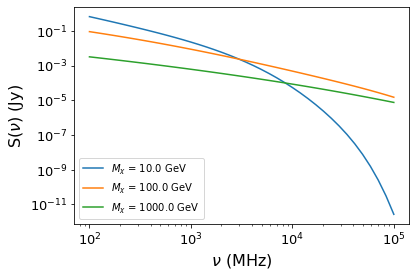

In [57]:
print(outData['calcData']['results']['units'])
for i in range(len(outData['calcData']['mWIMP'])):
    plt.plot(outData['calcData']['fSampleValues'],outData['calcData']['results']['finalData'][i],label=r"$M_\chi$ = "+str(outData['calcData']['mWIMP'][i])+" GeV")
plt.xscale("log")
plt.yscale("log")
plt.ylabel(r"S$(\nu)$ (Jy)",fontsize=16)
plt.xlabel(r"$\nu$ (MHz)",fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
plt.show()